In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
df = pd.read_csv('../data/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [2]:
df.isnull().sum()

id        0
text      0
author    0
dtype: int64

The plot below shows the distribution of words among each represented author. 

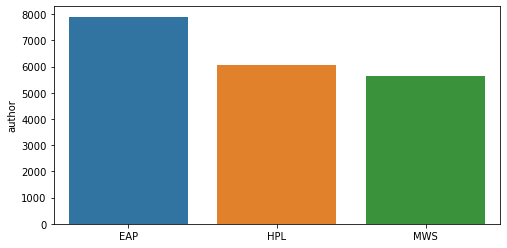

In [3]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['author'].unique(), y= df['author'].value_counts())
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42)
print('Text sample:', train['text'].iloc[0])
print('Author of this text:', train['author'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Text sample: This panorama is indeed glorious, and I should rejoice in it but for the excess of its glory.
Author of this text: EAP
Training Data Shape: (13117, 3)
Testing Data Shape: (6462, 3)


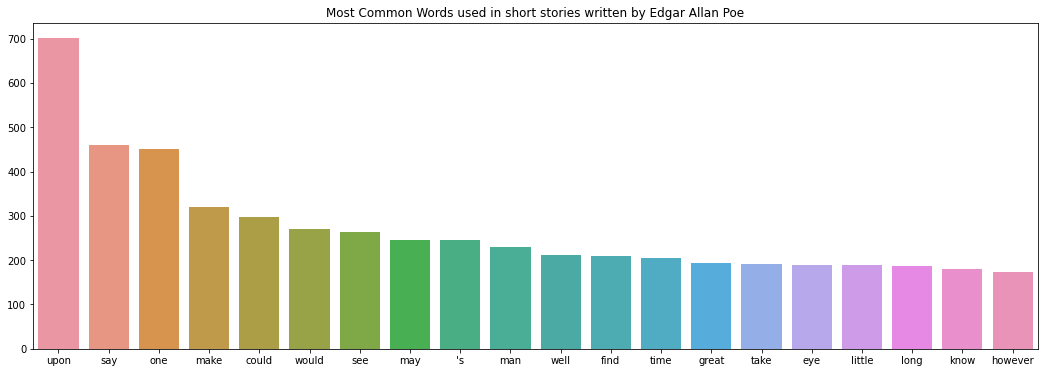

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)
EAP_text = [text for text in train[train['author'] == 'EAP']['text']]
HPL_text = [text for text in train[train['author'] == 'HPL']['text']]
MWS_text = [text for text in train[train['author'] == 'MWS']['text']]
EAP_clean = cleanup_text(EAP_text)
EAP_clean = ' '.join(EAP_clean).split()
HPL_clean = cleanup_text(HPL_text)
HPL_clean = ' '.join(HPL_clean).split()
MWS_clean = cleanup_text(MWS_text)
MWS_clean = ' '.join(MWS_clean).split()
EAP_counts = Counter(EAP_clean)
HPL_counts = Counter(HPL_clean)
MWS_counts = Counter(MWS_clean)
EAP_common_words = [word[0] for word in EAP_counts.most_common(20)]
EAP_common_counts = [word[1] for word in EAP_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=EAP_common_words, y=EAP_common_counts)
plt.title('Most Common Words used in short stories written by Edgar Allan Poe')
plt.show()

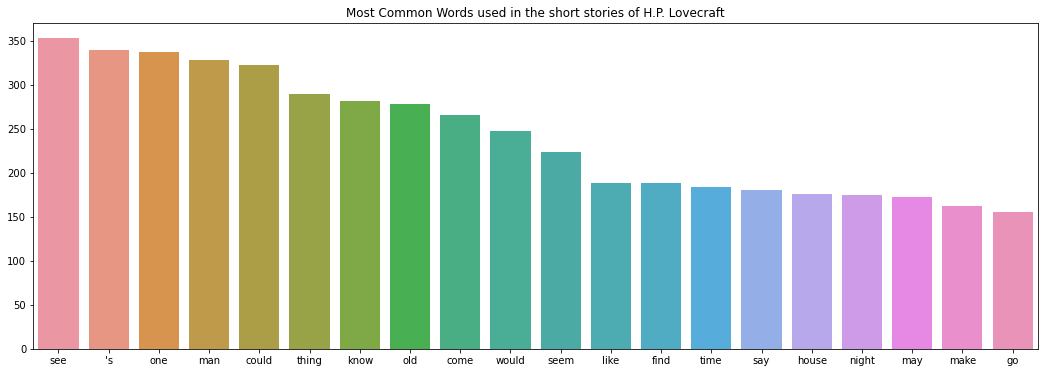

In [6]:
HPL_common_words = [word[0] for word in HPL_counts.most_common(20)]
HPL_common_counts = [word[1] for word in HPL_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=HPL_common_words, y=HPL_common_counts)
plt.title('Most Common Words used in the short stories of H.P. Lovecraft')
plt.show()

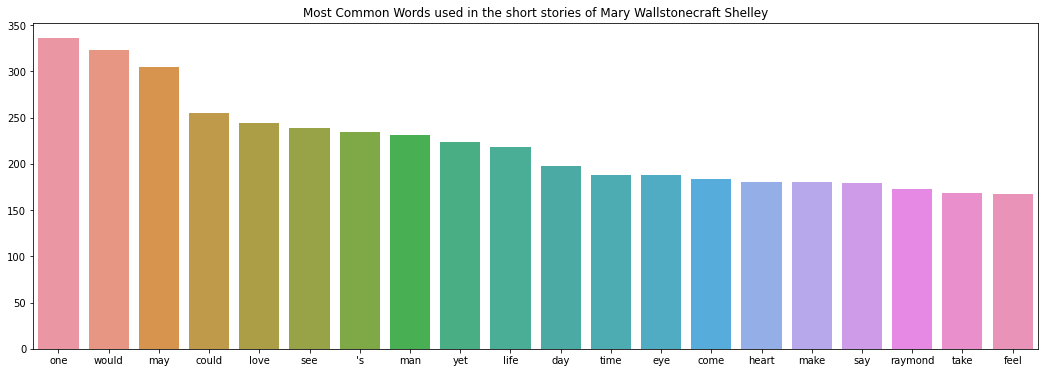

In [7]:
MWS_common_words = [word[0] for word in MWS_counts.most_common(20)]
MWS_common_counts = [word[1] for word in MWS_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=MWS_common_words, y=MWS_common_counts)
plt.title('Most Common Words used in the short stories of Mary Wallstonecraft Shelley')
plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [10]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()


In [13]:
test_unlabeled = pd.read_csv('../data/test.csv')

In [14]:

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train['text'].tolist()
labelsTrain1 = train['author'].tolist()
test1 = test['text'].tolist()
labelsTest1 = test['author'].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.7511606313834726
Top 10 features used to predict: 
Class 1 best: 
(-1.6360959587274835, 'brood')
(-1.6240568226981171, 'raymond')
(-1.500338639024595, 'fraction')
(-1.4875178136629446, 'adrian')
(-1.452580455524861, 'whilst')
(-1.445023320312973, 'perdita')
(-1.4151083584708068, 'hasten')
(-1.3977193455025823, 'squirmin')
(-1.37576716783777, 'kirwin')
(-1.3566507099803842, "n'bangus")
Class 2 best: 
(1.8254062281194678, 'oppodeldoc')
(1.620548352186066, 'wakefulness')
(1.5626292591751993, 'wyatt')
(1.44546355994779, 'color')
(1.4034037305685214, 'deadly')
(1.3952038280107801, 'comet')
(1.3912291878219536, 'scrutiny')
(1.373314128524482, 'foretell')
(1.3540732680270335, 'epoch')
(1.3525710150619301, 'dupin')
